# 1. 데이터 불러오기
- 필요한 라이브러리 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


- GPU 환경 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs) 데이터셋 불러오기
  - 120개 견종
  - 총 20,580장 이미지
    - 12,000장은 학습용 데이터셋
    - 8,580장은 평가용 데이터셋
- 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='~/aiffel/tensorflow_datasets',
)
print('=3')

=3


- 다운로드한 데이터 확인

In [4]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))
print("훈련 데이터셋 개수:", tf.data.experimental.cardinality(ds_train).numpy())
print("테스트 데이터셋 개수:", tf.data.experimental.cardinality(ds_test).numpy())

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)
훈련 데이터셋 개수: 12000
테스트 데이터셋 개수: 8580


In [5]:
ds = ds_train.take(1)

for i, example in enumerate(ds):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print("▶keys=", list(example.keys()))
    image = example["image"]
    file = example["image/filename"]
    label = example["label"]
    obj = example["objects"]
    print("▶image shape=", image.shape)
    #print(image)
    print("▶image/filename=", file)
    print("▶label=", label)
    print("▶objects=", obj)

▶keys= ['image', 'image/filename', 'label', 'objects']
▶image shape= (454, 383, 3)
▶image/filename= tf.Tensor(b'Images/n02106550-Rottweiler/n02106550_10714.jpg', shape=(), dtype=string)
▶label= tf.Tensor(83, shape=(), dtype=int64)
▶objects= {'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.09471366, 0.1462141 , 0.938326  , 0.74934727]], dtype=float32)>}


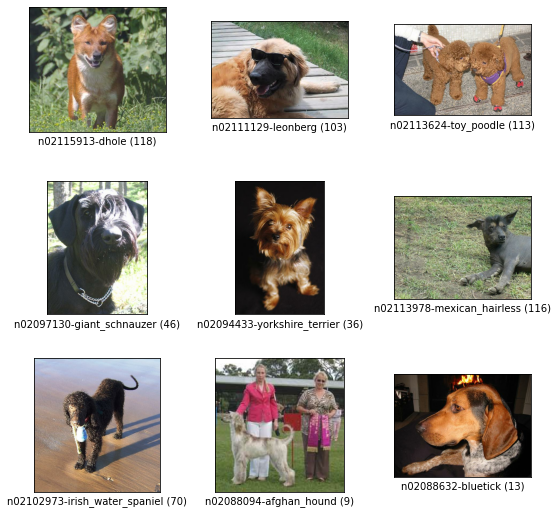

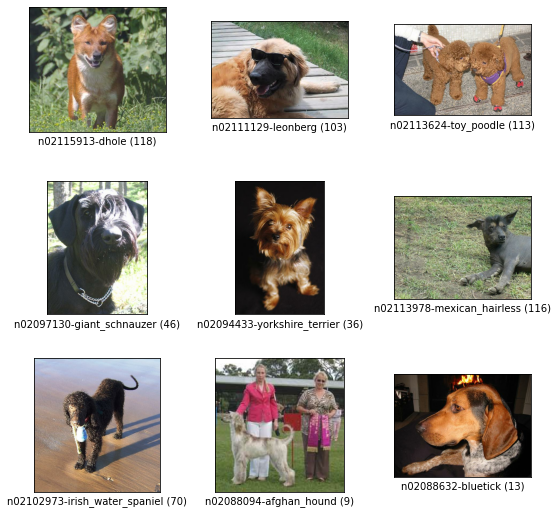

In [6]:
tfds.show_examples(ds_train, ds_info)

#  2. 기본 Augmentation 적용하기
### 텐서플로우 Random Augmentation API 사용하기


In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


- 전처리 함수 정의

In [8]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


- Augmentation 함수 apply_normalize_on_dataset() 정의
  - normalize, resize, augmentation, shuffle 적용
  - (주의해야 할 점) 테스트 데이터셋에는 augmentation, shuffle 적용하지 않음
  - 비교실험을 위해 with_aug 매개변수를 통해 augmentation 적용 여부 결정
  
- [tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

In [9]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)  #데이터 수=12,000개, 16개짜리 750묶음 (16,224,224,3)
    if not is_test:
        ds = ds.repeat() # 16x750을 무한대(?)로 반복한다.
        ds = ds.shuffle(200) # 배치(16개 뭉치)를 셔플...
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


# 3. 비교실험 하기

- 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델 불러오기
  - include_top: 마지막 fully connected layer 포함 여부
    - 이 레이어를 포함하지 않고 특성 추출기 부분만 불러와 필요에 맞게 수정된 fully connected layer를 붙여서 활용
    - 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수)가 다르기 때문

- 기본 데이터셋으로 학습시킬 ResNet 생성

In [10]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


- Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 생성
  - 기본 모델과 이름만 다름
  - 모델 실행(.fit 메서드 사용)시 다른 데이터를 사용

In [11]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


- 데이터 로드

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='~/aiffel/tensorflow_datasets',
)

- 함수 apply_normalize_on_dataset() 사용 데이터 전처리 및 생성
  - 훈련용 기본 데이터: with_aug = False
  - 훈련용 Augmentation 적용 데이터: with_aug = True
  - 테스트 데이터: is_test=True. augmentation, shuffle 적용하지 않음

In [13]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


- 기본 모델 훈련

In [14]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


750/750 [==============================] - 183s 197ms/step - loss: 2.2129 - accuracy: 0.4505 - val_loss: 3.1391 - val_accuracy: 0.2410
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.7023 - accuracy: 0.8089 - val_loss: 1.0492 - val_accuracy: 0.6940
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2225 - accuracy: 0.9545 - val_loss: 0.9458 - val_accuracy: 0.7229
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0627 - accuracy: 0.9952 - val_loss: 0.9128 - val_accuracy: 0.7402
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0282 - accuracy: 0.9989 - val_loss: 0.9305 - val_accuracy: 0.7358
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0178 - accuracy: 0.9992 - val_loss: 0.9340 - val_accuracy: 0.7408
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.9501 - val_accura

- Augmentation 적용 모델 훈련

In [15]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 161s 206ms/step - loss: 2.3049 - accuracy: 0.4277 - val_loss: 3.1656 - val_accuracy: 0.2309
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.9424 - accuracy: 0.7325 - val_loss: 1.3508 - val_accuracy: 0.6170
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.5169 - accuracy: 0.8580 - val_loss: 1.0418 - val_accuracy: 0.6978
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2787 - accuracy: 0.9318 - val_loss: 1.0026 - val_accuracy: 0.7113
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.1560 - accuracy: 0.9700 - val_loss: 0.9847 - val_accuracy: 0.7203
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0851 - accuracy: 0.9875 - val_loss: 0.9783 - val_accuracy: 0.7330
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0572 - accuracy: 0.9923 - val_loss: 0.9508 -

- 훈련 과정 시각화

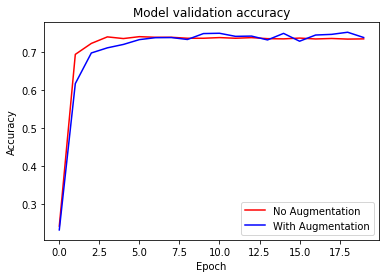

In [16]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='lower right')
plt.show()

- 조금 더 확대해서 살펴보기

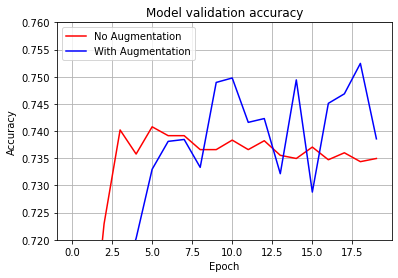

In [17]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

- Augmentation 적용한 경우가 보다 천천히 학습되지만
- EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성됨

# 4. Cutmix Augmentation

- [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
  - 네이버 클로바(CLOVA)에서 발표
  - 이미지 데이터를 자르고 섞음

- [Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook)
  - 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp을 확인할 수 있음

## 4-1. 이미지 섞기
- 두 개의 이미지 섞기: **배치 내의** 이미지 두 개를 골라서 섞기
- 바운딩 박스(bounding box): 이미지에서 잘라서 섞는 영역

- 예시를 위해 훈련데이터셋에서 이미지 2개 가져오기

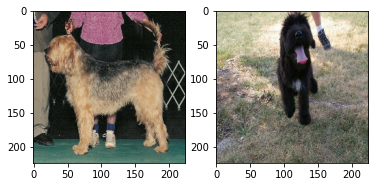

In [18]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

- 첫 번째 이미지 a를 바탕 이미지로 하고, 거기에 삽입할 두 번째 이미지 b가 있을 때, <br> **a에 삽입될 영역의 바운딩 박스의 위치**를 결정하는 함수 구현 
  - 이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우
  - CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현
  - 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현

In [19]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(52, shape=(), dtype=int32) tf.Tensor(222, shape=(), dtype=int32)
y :  tf.Tensor(117, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


- 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, <br> 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수

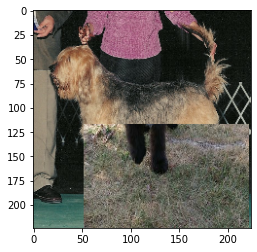

In [20]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

## 4-2. 라벨 섞기
- CutMix에서는 면적에 비례해서 라벨 섞기 수행
- 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줌
  - A 클래스를 가진 원래 이미지 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록
- **라벨 벡터**는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 **원-핫 인코딩**이 아니라 **A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식**을 사용


In [21]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.6374761, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.3625239, 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

- mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수 구현

In [22]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# 5. Mixup Augmentation

- [Mixup:Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
  - Mixup: 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식
  - 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞음

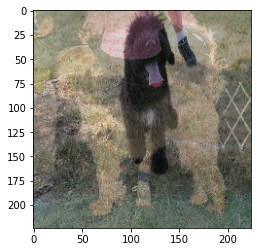

In [23]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()

- 배치 단위의 mixup() 함수

In [24]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# 6. 프로젝트: CutMix 또는 Mixup 비교실험 하기
(1) No Augmentation <br> 
(2) 기본 Augmentation  
(3) 기본 + CutMix 적용  
(4) 기본 + Mixup 적용   
- 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.


- 주요 라이브러리 버전 확인

In [25]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


## 6-1. Augmentation을 적용한 데이터셋 만들기

#### CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()
- batch() 함수 뒤에 CutMix가 오도록 만들어야 함  
- CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 배치 단위로 데이터셋을 정렬 후 CutMix 적용

In [26]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [27]:
def one_hot(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    one_hot_imgs = []
    one_hot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        label_a = tf.one_hot(label_a, num_classes)
        #j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        #image_b = image[j]
        #label_b = label[j]
        #x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        one_hot_imgs.append(image_a)
        one_hot_labels.append(label_a)

    one_hot_imgs = tf.reshape(tf.stack(one_hot_imgs), (batch_size, img_size, img_size, 3))
    one_hot_labels = tf.reshape(tf.stack(one_hot_labels), (batch_size, num_classes))
    return one_hot_imgs, one_hot_labels

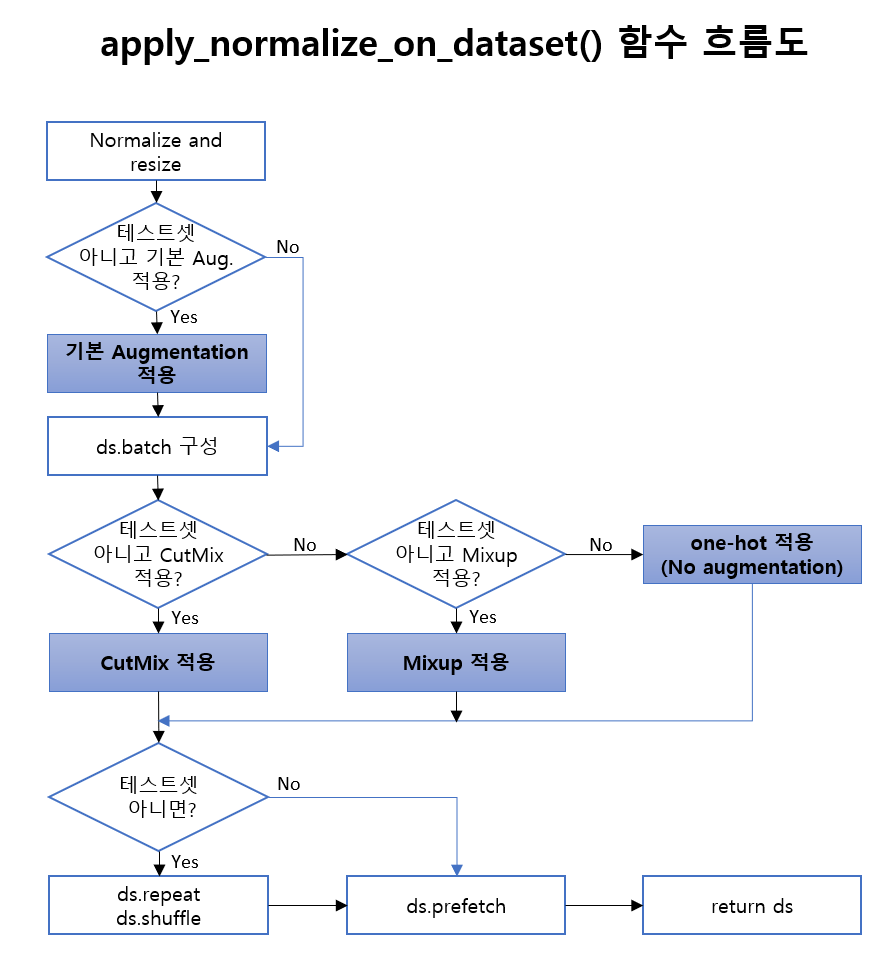

In [28]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2) # 데이터 정규화 및 리사이즈
    
    if not is_test and with_aug:      # ▶(2)기본 Augmentation 적용
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)  # 배치 구성
    
    if not is_test and with_cutmix:   # ▶(3) 기본 + CutMix 적용
        ds = ds.map(cutmix, num_parallel_calls=2)
        
    elif not is_test and with_mixup:  # ▶(4) 기본 + Mixup 적용
        ds = ds.map(mixup, num_parallel_calls=2)
        
    else:                              # ▶(0) No Augmentation
        ds = ds.map(one_hot, num_parallel_calls=2)
        
    if not is_test:   # 테스트 데이터셋 제외
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


## 6-2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

- 데이터 로드

In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='~/aiffel/tensorflow_datasets',
)

- 훈련용 데이터셋 만들기

In [30]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True) # 추가
ds_train_mixup  = apply_normalize_on_dataset(ds_train, with_mixup=True) # 추가
ds_test         = apply_normalize_on_dataset(ds_test,  is_test=True)
print('=3')

=3


- 기본 + CutMix Augmentation 모델 만들기

In [31]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


- 기본 + Mixup Augmentation 모델 만들기

In [32]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


## 6-3. 모델 훈련하기
- 주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!
  - cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

- 기본 + CutMix Augmentation 모델 훈련하기

In [33]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 207ms/step - loss: 3.8461 - accuracy: 0.2070 - val_loss: 3.4021 - val_accuracy: 0.1971
Epoch 2/20
750/750 [==============================] - 170s 226ms/step - loss: 2.9729 - accuracy: 0.4267 - val_loss: 1.4951 - val_accuracy: 0.5877
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 2.6398 - accuracy: 0.5339 - val_loss: 1.2109 - val_accuracy: 0.6636
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4305 - accuracy: 0.6025 - val_loss: 1.2137 - val_accuracy: 0.6610
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2596 - accuracy: 0.6492 - val_loss: 1.3516 - val_accuracy: 0.6372
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 2.1565 - accuracy: 0.6857 - val_loss: 1.2860 - val_accuracy: 0.6568
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.0659 - accuracy: 0.7124 - val_loss: 1.1672 -

- 기본 + Mixup Augmentation 모델 훈련하기

In [34]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 207ms/step - loss: 3.6919 - accuracy: 0.2443 - val_loss: 3.9631 - val_accuracy: 0.1305
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 2.8414 - accuracy: 0.4861 - val_loss: 1.4166 - val_accuracy: 0.5983
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5473 - accuracy: 0.5925 - val_loss: 1.3627 - val_accuracy: 0.6240
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.3735 - accuracy: 0.6557 - val_loss: 1.2300 - val_accuracy: 0.6590
Epoch 5/20
750/750 [==============================] - 170s 227ms/step - loss: 2.2451 - accuracy: 0.7147 - val_loss: 1.2089 - val_accuracy: 0.6705
Epoch 6/20
750/750 [==============================] - 170s 227ms/step - loss: 2.1523 - accuracy: 0.7417 - val_loss: 1.2249 - val_accuracy: 0.6616
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 2.0651 - accuracy: 0.7697 - val_loss: 1.3820 -

## 6-4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

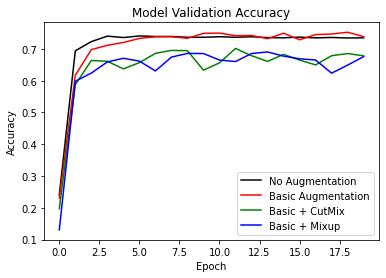

In [40]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'b')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'Basic + CutMix', 'Basic + Mixup'], loc='lower right')
plt.show()

- 확대해서 보기

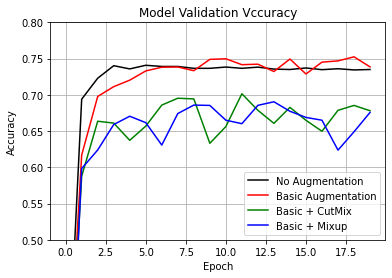

In [39]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'b')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'Basic + CutMix', 'Basic + Mixup'], loc='lower right')


plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 6-5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

### [네 가지 모델 성능 비교] 

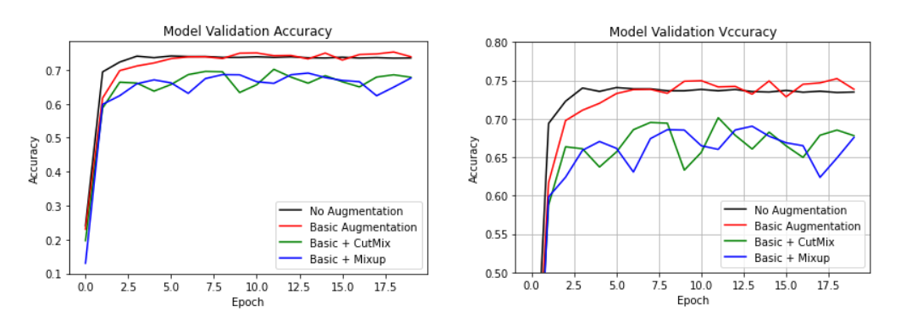

1. Validation 정확도: 기본 Augmentation (0.75 정도) > No Augmentation (0.73 정도) > (기본 + CutMix, 기본 + Mixup) (0.68 정도)
2. 기본 Augmentation 적용시 적용하지 않았을 때에 비해 Epoch 10 이후에서 3% (= 0.02/0.73) 정도의 성능 향상이 있는 것으로 보인다.
   - Epoch 10 이전에는 적용하지 않았을 때(No Augmentation)의 성능이 좋다.
   - No Augmentation의 경우가 Augmentation 적용시보다 상대적으로 빨리 과적합된다고 해석할 수 있다.
   - Augmentation을 적용한 경우에 보다 다양한 훈련데이터를 학습시키므로 Epoch가 진행됨에 따라 Validation 정확도가 상대적으로 더 높아질 것으로 예상할 수 있다.
3. 기본 Augmentation에 CutMix 또는 Mixup Augmentation을 추가한 모델의 성능은 Epoch 20까지는 No Augmentation 및 기본 Augmentation 적용 모델보다 나쁘다.
   - 위에 언급한 것과 같은 맥락에서 Epoch가 많이 진행될수록 기본+CutMix 또는 기본+Mixup 모델이 No Augmentation 및 기본 Augmentation 적용 모델보다 훨씬 다양한 훈련데이타를 생성하여 학습을 진행시킬 것이므로 Validation 정확도가 향상될 것으로 예상할 수 있다.
   - 논문에서도 Epoch 200 이후에 CutMix 적용 모델의 성능이 좋음을 보여준다 (아래 그림). <br> 
   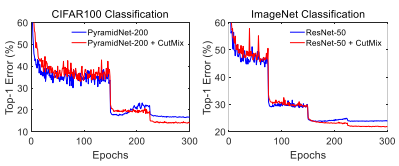

## 프로젝트 평가

| 평가문항 | 상세기준 | 수행 결과 |
|:---|:---|:---|
| 1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? | CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다. | 수렴하였음. 6-3 부분 참고 |
| 2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? | Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함 | Epoch 20까지 실행시킨 결과 기본 Augmentation 적용시 3% 정도 향상. CutMix와 Mixup은 성능이 더 나쁨. 성능 향상 확인을 위해서는, (논문을 보면) Epoch 200 이상 실행시켜야 할 것으로 보임 (시간 제약으로 못함) |
| 3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? | 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다. | 6-4, 6-5 부분 참고 |


## [코드 목차]

1. 데이터 불러오기
2. 기본 Augmentation 적용하기
3. 비교 실험하기
4. CutMix Augmentation
  - 4-1. 이미지 섞기
  - 4-2. 라벨 섞기
5. Mixup Augmentation
6. 프로젝트: CutMix 또는 Mixup 비교실험 하기
  - 6-1. Augmentation을 적용한 데이터셋 만들기
  - 6-2. 모델 만들기
  - 6-3. 모델 훈련하기
  - 6-4. 훈련과정 시각화 하기
  - 6-5. Augmentation에 의한 모델 성능 비교

### [회고]
1. tfds.load 및 미니배치 생성과 관련된 코드를 상세히 살펴보고 이해하고자 하였다.
  - ds.shuffle과 관련해서는 아직도 세부 내용을 완전히 이해하지 못하였다.
2. 이 과정에서 퍼실님을 포함한 동료들과의 토론이 있어서 도움을 많이 받았다.
3. 훈련데이터 생성(다운로드 등), 데이터의 속성 파악, 데이터 전처리 등과 관련한 표준 프로세스와 관련 함수들의 정리가 필요하다.
  - 제일 기본이 되는 작업인데 정리가 되지 않는다.
  - tensorflow를 사용하는 경우, numpy를 사용하는 경우, pandas 데이터프레임를 사용하는 경우 등 각각에 대한 정리가 필요할 것이다.
4. 시간과 Computing Resource가 허락된다면 Epoch=300으로 해서 성능 확인을 해보면...
  - 내가 만든 코드가 틀렸을 수도 있고 ㅎㅎ
5. 내가 만든 코드가 맞다는 것을 보장 받을 수 있는 방법은 무엇인지 궁금하다.
  - one_hot 함수는 cutmix 함수를 변형해서 만들었다.